In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Basic Active Learning

>Basics of using active learning

## Active Learning

Generative models give us the ability to rapidly produce millions of novel chemical structures. While this is great for generating designs, it can lead to an imbalance between the computational effort required to generate structures versus evaluating structures. 

It is not uncommon to encounter molecular score functions that require minutes  to hours of compute time per compound to generate a score. The lower end of the scale includes methods like docking, which can take low digit minutes per compound depending on the docking config, to large scale molecular simulations which might require an hour or more of GPU compute per compound.

This imbalance is particularly significant when generative models are involved. Say I want to evaluate my compounds with docking, and my docking config requires 2 minutes of CPU compute per compound. With a generative model, I can easily generate ~10 million compounds in ~15 minutes. Evaluating all these compounds would then require 20 million minutes of compute time. At time of writing, AWS is charging about 0.096 dollars/vCPU hour. This means 20 million minutes of compute time will cost about $32,000. 

Given that most compounds are likely duds, this will be a huge waste of money. Cash burn is compounded when this is projected out to many model runs over the course of a year.

How can we deal with this? The solution is __active learning__. Active learning is a process where we use a simple, cheap model to approximate our desired score function. We use the cheap score function to generate predictions for a set of compounds we want to score. Then we sample a batch of compounds from the dataset based on the predicted score. We send these samples to the slow, high cost score function. Then we use the results of the slow score to update our simple score.

By iterating on this process, we can find most of the top scoring compounds on a large dataset by screening less than 5\% of the dataset with our slow score function. This notebook gives a minimal example for using active learning to mine a dataset

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys

sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Download Data

We will use the ZINC 250k dataset as our test dataset. This includes 250k compounds from the ZINC library

In [ ]:
# download data
# ! wget https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv


In [ ]:
df = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')

## Score Function

Since this is a tutorial, we will use a cheap score function as our target score. In a more realistic setting, this would be something more computationally intensive like docking.

The score function we will use is a MLP model that uses molecular fingerprints to predict the binding affinity of a compound against EGFR. This is a simple and flawed score function, but we use it for the purpose of showing how to use the framework without requiring a significant compute budget to explore the library.

For this purpose of this exercise, we treat the score function as an oracle that gives ground truth predictions

In [ ]:
oracle_model = MLP(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2], outrange=[0,15])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

oracle_agent = PredictiveAgent(oracle_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

oracle_agent.load_state_dict(model_from_url('egfr_affinity_mlp.pt'))

oracle_agent.model.eval();

freeze(oracle_agent.model)

reward = Reward(oracle_agent.predict_data, weight=1., bs=4096)

aff_reward = RewardCallback(reward, 'affinity')

## Initial Predictions

We generate predictions from the oracle for all compounds in the dataset. In a real setting with a computationally expensive score function, we wouldn't do this (in fact we want to use active learning to specifically avoid this). But since this is a tutorial using a cheap oracle, we can generate all our ground truth predictions and use them to evaluate how well the active learning process works at finding high scoring compounds.

We will evaluate the performance of the active learning process by what percentage of compounds above a given score are found relative to the number of compounds screened

In [ ]:
with torch.no_grad():
    preds = oracle_agent.predict_data_batch(df.smiles.values, 4096)
    
df['targs'] = preds.detach().cpu().numpy()
np.percentile(df.targs, 99), df.targs.max()

(6.475615110397339, 8.208409)

## Active Learning Module

Active learning is implemented as a `Buffer` in the MRL framework. Normally a buffer holds a set of unscored compounds and samples from this compound set randomly.

With active learning, we use a model to generate predictions for every compound in the buffer, and weight our sampling by these predictions. Then we train the predictive model every batch based on the actual rewards earned.

Our predictive model will be a MLP model that uses molecular fingerprints to generate predictions

In [ ]:
active_model = MLP(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2], outrange=[0,15])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

active_agent = PredictiveAgent(active_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

p_total = 1.
refresh_predictions = 5     # update predictions every 5 batches
pred_bs = 2048              # prediction batch size
supervised_frequency = 10   # how often to do offline supervised training 
supervised_epochs = 3       # number of epochs for offline training
supervised_bs = 32          # supervised training bs
supervised_lr = 1e-3        # supervised training learning rate
pct_argmax=0.6              # percent of batch to sample via argmax rather than weighted sampling

buffer = PredictiveBuffer(p_total,
                          refresh_predictions, 
                          active_agent,
                          pred_bs,
                          supervised_frequency,
                          supervised_epochs,
                          supervised_bs,
                          supervised_lr, 
                          pct_argmax=pct_argmax)

buffer.add(list(df.smiles.values))

## Environment

Now we set up our environment. This is the most simple case where we have a single reward term. The active learning framework can be expanded to integrate with generative models, different samplers, or multiple rewards

In [ ]:
# set_global_pool(min(16, os.cpu_count()))

In [ ]:
env = Environment(rewards=[aff_reward], buffer=buffer)

## Train

Now we run the training process. We'll train for 60 batches of 128 compounds, for a total of 7680 compounds screened, about 3% of the library. Then we will evaluate how many of the top compounds were recovered

In [ ]:
env.fit(128, 90, 60, 3)

iterations,rewards,rewards_final,new,diversity,bs,predictive_buffer_loss,predictive_buffer_preds,affinity
0,5.409,5.409,1.000,1.000,128,9.311,8.012,5.409
3,5.273,5.273,1.000,1.000,128,6.118,7.240,5.273
6,5.452,5.452,1.000,1.000,128,2.711,6.558,5.452
9,5.299,5.299,1.000,1.000,128,1.844,6.026,5.299
12,5.443,5.443,1.000,1.000,128,0.824,5.176,5.443
15,5.350,5.350,1.000,1.000,128,0.697,5.077,5.350
18,5.458,5.458,1.000,1.000,128,0.741,5.045,5.458
21,5.684,5.684,1.000,1.000,128,0.302,5.449,5.684
24,5.613,5.613,1.000,1.000,128,0.312,5.750,5.613
27,5.649,5.649,1.000,1.000,128,0.316,5.901,5.649


## Analysis

We can see how many of the top compounds we found.

Looking at the environment log, we see we screened about 3% of the total library

In [ ]:
100*env.log.df.shape[0]/df.shape[0] # percent of compounds screened

3.0787115912689664

This plot shows what percentage of compounds we found above a given score cutoff. The vertical red lines correspond to the 90th, 95th, 99th and 99.9th score percentiles in the dataset.

We can see from the plot that by screening 3% of the library, we found ~80% of the top 0.1% of compounds in the dataset

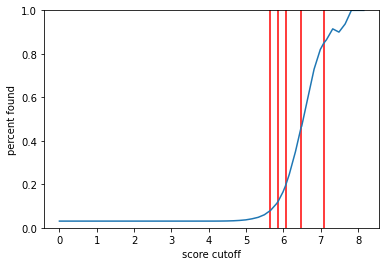

In [ ]:
cutoffs = list(np.linspace(0,8.15))
cutoffs += [np.percentile(df.targs, i) for i in [90, 95, 99, 99.9]]
cutoffs = sorted(cutoffs)
scores = [env.log.df[env.log.df.rewards>cutoff].shape[0]/df[df.targs>cutoff].shape[0]
 for cutoff in cutoffs]

plt.plot(cutoffs,scores)
lines = [np.percentile(df.targs, i) for i in [80, 90, 95, 99, 99.9]]
for l in lines:
    plt.vlines(l, 0, 1, color='r')
plt.ylim(0,1)
plt.xlabel('score cutoff')
plt.ylabel('percent found');

We can of course continue sampling to get a deeper evaluation of the library

In [ ]:
env.fit(128, 90, 30, 3)

iterations,rewards,rewards_final,new,diversity,bs,predictive_buffer_loss,predictive_buffer_preds,affinity
60,5.987,5.987,1.000,1.000,128,0.139,6.219,5.987
63,6.012,6.012,1.000,1.000,128,0.110,5.808,6.012
66,6.006,6.006,1.000,1.000,128,0.060,6.033,6.006
69,5.893,5.893,1.000,1.000,128,0.127,6.165,5.893
72,5.946,5.946,1.000,1.000,128,0.094,5.768,5.946
75,5.919,5.919,1.000,1.000,128,0.063,5.853,5.919
78,5.944,5.944,1.000,1.000,128,0.085,6.032,5.944
81,6.025,6.025,1.000,1.000,128,0.123,5.781,6.025
84,5.878,5.878,1.000,1.000,128,0.063,5.822,5.878
87,5.929,5.929,1.000,1.000,128,0.047,5.978,5.929


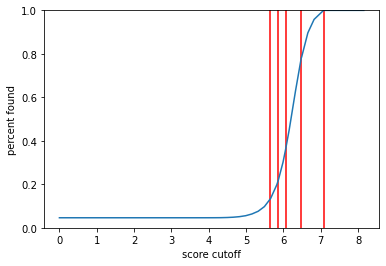

In [ ]:
cutoffs = list(np.linspace(0,8.15))
cutoffs += [np.percentile(df.targs, i) for i in [90, 95, 99, 99.9]]
cutoffs = sorted(cutoffs)
scores = [env.log.df[env.log.df.rewards>cutoff].shape[0]/df[df.targs>cutoff].shape[0]
 for cutoff in cutoffs]

plt.plot(cutoffs,scores)
lines = [np.percentile(df.targs, i) for i in [80, 90, 95, 99, 99.9]]
for l in lines:
    plt.vlines(l, 0, 1, color='r')
plt.ylim(0,1)
plt.xlabel('score cutoff')
plt.ylabel('percent found');